<a href="https://colab.research.google.com/github/yananma/5_programs_per_day/blob/master/0520.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 9.11 样式迁移

In [0]:
!pip install d2lzh mxnet-cu100

In [2]:
!git clone https://github.com/d2l-ai/d2l-zh.git

Cloning into 'd2l-zh'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15702 (delta 9), reused 8 (delta 4), pack-reused 15685
Receiving objects: 100% (15702/15702), 159.56 MiB | 32.22 MiB/s, done.
Resolving deltas: 100% (11132/11132), done.


In [0]:
!mkdir ../img

In [0]:
!cp ./d2l-zh/img/rainier.jpg ../img/

In [0]:
!cp ./d2l-zh/img/autumn_oak.jpg ../img/

In [0]:
%matplotlib inline
from mxnet import autograd, gluon, image, init, nd
import d2lzh as d2l
from mxnet.gluon import model_zoo, nn
import time

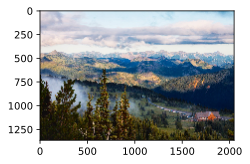

In [78]:
d2l.set_figsize()  
content_img = image.imread('../img/rainier.jpg')
d2l.plt.imshow(content_img.asnumpy());

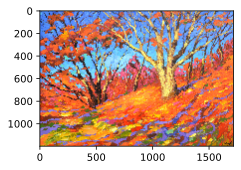

In [79]:
style_img = image.imread('../img/autumn_oak.jpg')
d2l.plt.imshow(style_img.asnumpy());

In [0]:
rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std 
    return img.transpose((2, 0, 1)).expand_dims(axis=0)

def postprocess(img):
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1, 2, 0)) * rgb_std + rgb_mean).clip(0, 1)

In [0]:
pretrained_net = model_zoo.vision.vgg19(pretrained=True)

In [0]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [0]:
net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

In [0]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles 

In [0]:
def get_contents(image_shape, ctx):
    content_X = preprocess(content_img, image_shape).copyto(ctx)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

In [0]:
def get_styles(image_shape, ctx):
    style_X = preprocess(style_img, image_shape).copyto(ctx)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [0]:
def content_loss(Y_hat, Y):
    return (Y_hat - Y).square().mean()

In [0]:
def gram(X):
    num_channels, n = X.shape[1], X.size // X.shape[1]
    X = X.reshape((num_channels, n))
    return nd.dot(X, X.T) / (num_channels * n)

In [0]:
def style_loss(Y_hat, gram_Y):
    return (gram(Y_hat) - gram_Y).square().mean()

In [0]:
def tv_loss(Y_hat):
    return 0.5 * ((Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).abs().mean() +
            (Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).abs().mean())

In [0]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight 
    l = nd.add_n(*styles_l) + nd.add_n(*contents_l) + tv_l 
    return contents_l, styles_l, tv_l, l


In [0]:
class GeneratedImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()

In [0]:
def get_inits(X, ctx, lr, styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam', {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [0]:
def train(X, contents_Y, styles_Y, ctx, lr, max_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, ctx, lr, styles_Y)
    for i in range(max_epochs):
        start = time.time()
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram
            )
        l.backward()
        trainer.step(1)
        nd.waitall()
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, TV loss %.2f, %.2f sec'
            % (i, nd.add_n(*contents_l).asscalar(), 
               nd.add_n(*styles_l).asscalar(), tv_l.asscalar(), 
               time.time() - start))
        if i % lr_decay_epoch == 0 and i != 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
            print('change lr to %.1e' % trainer.learning_rate)
    return X 

In [95]:
ctx, image_shape = d2l.try_gpu(), (225, 150)
net.collect_params().reset_ctx(ctx)
content_X, contents_Y = get_contents(image_shape, ctx)
_, styles_Y = get_styles(image_shape, ctx)
output = train(content_X, contents_Y, styles_Y, ctx, 0.01, 500, 200)

epoch  50, content loss 10.11, style loss 29.38, TV loss 3.46, 0.06 sec
epoch 100, content loss 7.51, style loss 15.45, TV loss 3.89, 0.06 sec
epoch 150, content loss 6.32, style loss 10.37, TV loss 4.15, 0.06 sec
epoch 200, content loss 5.65, style loss 8.11, TV loss 4.29, 0.06 sec
change lr to 1.0e-03
epoch 250, content loss 5.58, style loss 7.94, TV loss 4.30, 0.06 sec
epoch 300, content loss 5.52, style loss 7.79, TV loss 4.31, 0.06 sec
epoch 350, content loss 5.47, style loss 7.64, TV loss 4.31, 0.06 sec
epoch 400, content loss 5.41, style loss 7.49, TV loss 4.32, 0.06 sec
change lr to 1.0e-04
epoch 450, content loss 5.40, style loss 7.47, TV loss 4.32, 0.06 sec


In [0]:
d2l.plt.imsave('../img/neural-style-1.png', postprocess(output).asnumpy())

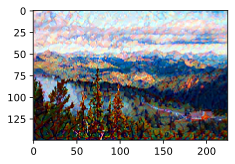

In [97]:
neural_style1 = image.imread('../img/neural-style-1.png')
d2l.plt.imshow(neural_style1.asnumpy());

In [98]:
image_shape = (450, 300)
_, content_Y = get_contents(image_shape, ctx)
_, style_Y = get_styles(image_shape, ctx)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, ctx, 0.01, 300, 100)
d2l.plt.imsave('../img/neural-style-2.png', postprocess(output).asnumpy())

epoch  50, content loss 13.80, style loss 13.66, TV loss 2.38, 0.18 sec
epoch 100, content loss 9.52, style loss 8.75, TV loss 2.65, 0.19 sec
change lr to 1.0e-03
epoch 150, content loss 9.21, style loss 8.42, TV loss 2.68, 0.18 sec
epoch 200, content loss 8.94, style loss 8.14, TV loss 2.70, 0.18 sec
change lr to 1.0e-04
epoch 250, content loss 8.91, style loss 8.11, TV loss 2.70, 0.18 sec


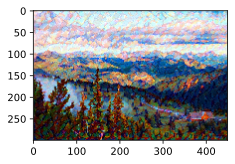

In [99]:
neural_style2 = image.imread('../img/neural-style-2.png')
d2l.plt.imshow(neural_style2.asnumpy());